In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx
/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'transformer_time_series_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/50


I0000 00:00:1730622181.740528      95 service.cc:145] XLA service 0x7ba660007240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730622181.740593      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 59/179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3596 - mae: 0.3449

I0000 00:00:1730622185.525375      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.1574 - mae: 0.1890 - val_loss: 0.0357 - val_mae: 0.1844
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024 - mae: 0.0317 - val_loss: 0.0378 - val_mae: 0.1909
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - mae: 0.0275 - val_loss: 0.0284 - val_mae: 0.1649
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - mae: 0.0232 - val_loss: 0.0123 - val_mae: 0.1053
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - mae: 0.0206 - val_loss: 0.0182 - val_mae: 0.1296
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.1262e-04 - mae: 0.0188 - val_loss: 0.0152 - val_mae: 0.1190
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - mae: 0.0174 - val_loss: 0.0170 - val_mae: 0.1258
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0393e-04 - mae: 0.0163 - val_loss: 0.0189 - val_mae: 0.1334
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - los

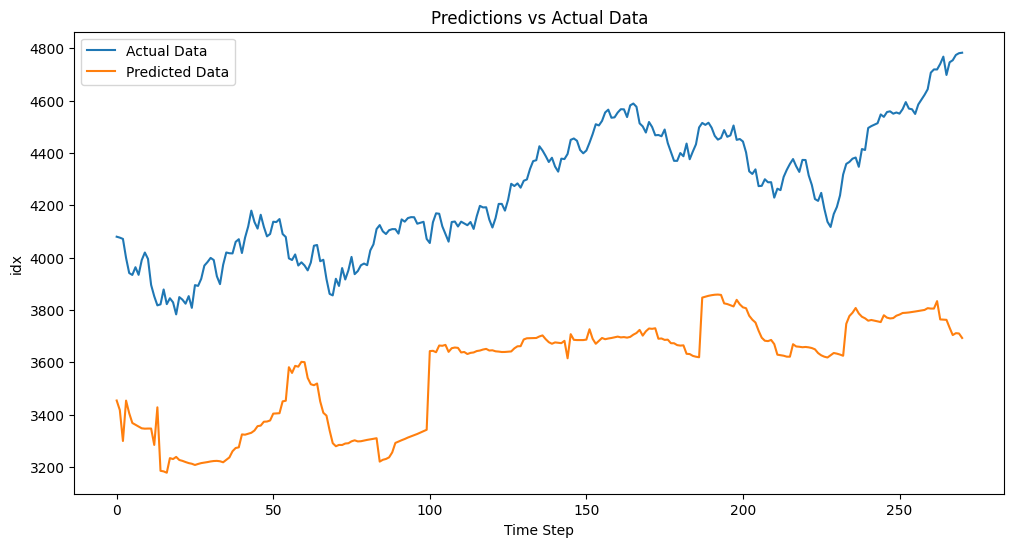

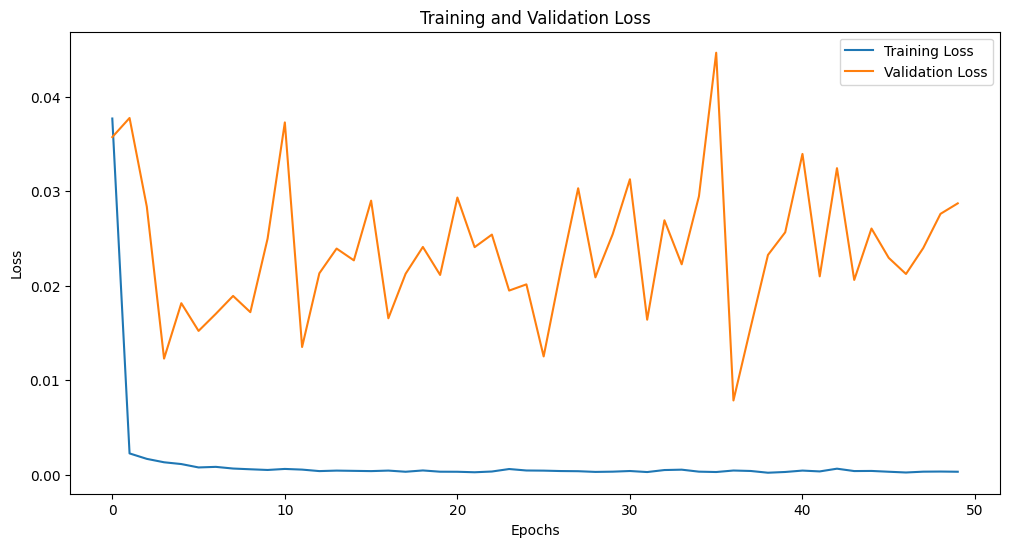

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout, Input
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load datasets
exogenous_data_path = '/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx'
training_data_path = '/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx'

exogenous_data = pd.read_excel(exogenous_data_path)
training_data = pd.read_excel(training_data_path)

# Extract necessary columns (drop 'Date' and keep 'idx' as target)
data = training_data.drop('Date', axis=1)

# Normalize the data for Transformer
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Prepare the training and validation sets
train_size = int(len(data_scaled) * 0.95)  # Use 95% for training
train, test = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 1:])  # Input features (all except idx)
        y.append(dataset[i + time_step, 0])  # Target (idx column)
    return np.array(X), np.array(y)

# Define time step (lookback window)
time_step = 30  # Increase to capture more historical context

# Create the datasets
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Define a sophisticated Transformer-based model
class TransformerTimeSeriesModel(tf.keras.Model):
    def __init__(self, num_heads, ff_dim, num_features):
        super(TransformerTimeSeriesModel, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=num_features)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation="relu"), Dense(num_features)])
        self.dropout = Dropout(0.1)
        
    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)  # Self-attention
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Set model parameters
num_heads = 4  # Increase for more attention heads
ff_dim = 128  # Feed-forward layer size
num_features = X_train.shape[2]  # Number of features

# Inputs
inputs = Input(shape=(time_step, num_features))

# Transformer layer
transformer_block = TransformerTimeSeriesModel(num_heads=num_heads, ff_dim=ff_dim, num_features=num_features)
x = transformer_block(inputs)

# Additional layers for better generalization
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)  # Dropout to prevent overfitting
x = Dense(32, activation='relu')(x)

# Output layer to predict the target (idx)
outputs = Dense(1)(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))], axis=1))[:, 0]

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)

train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Print model accuracy and performance
print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train R2: {train_r2}, Test R2: {test_r2}')
print(f'Train MAPE: {train_mape}%, Test MAPE: {test_mape}%')

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Data')
plt.plot(test_predict, label='Predicted Data')
plt.title('Predictions vs Actual Data')
plt.xlabel('Time Step')
plt.ylabel('idx')
plt.legend()
plt.show()

# Visualize training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'transformer_time_series_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.1186 - mae: 0.2233 - val_loss: 0.0505 - val_mae: 0.2135 - learning_rate: 0.0010
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - mae: 0.0817 - val_loss: 0.1462 - val_mae: 0.3776 - learning_rate: 0.0010
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mae: 0.0649 - val_loss: 0.1442 - val_mae: 0.3767 - learning_rate: 0.0010
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0566 - val_loss: 0.0265 - val_mae: 0.1548 - learning_rate: 0.0010
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mae: 0.0515 - val_loss: 0.0236 - val_mae: 0.1486 - learning_rate: 0.0010
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0393 - val_loss: 0.0375 - val_mae: 0.1891 - learning_rate: 0.0010
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - mae: 0.0356 - val_loss: 0.0527 - val_mae: 0.2263 - learning_rate: 0.0010
Epoch 8/100

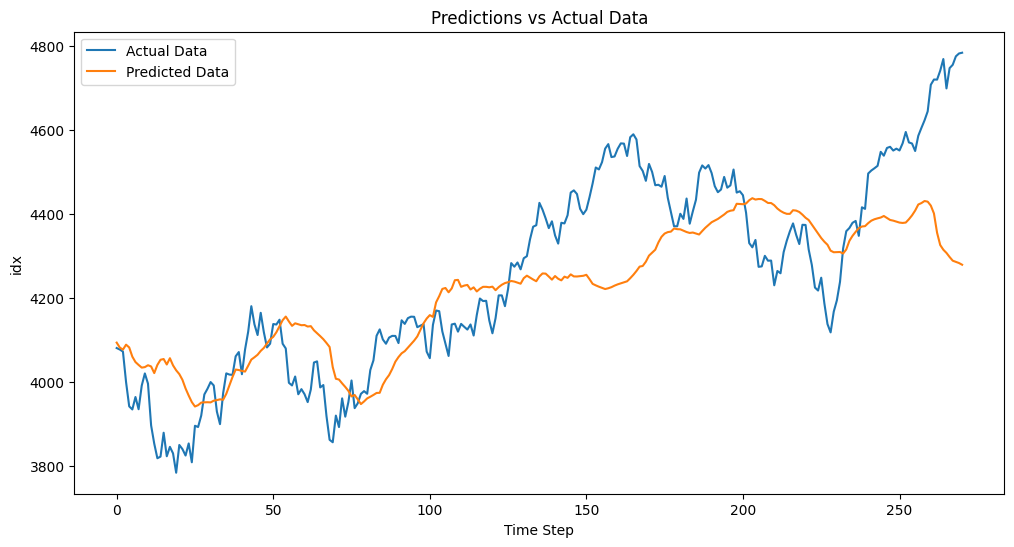

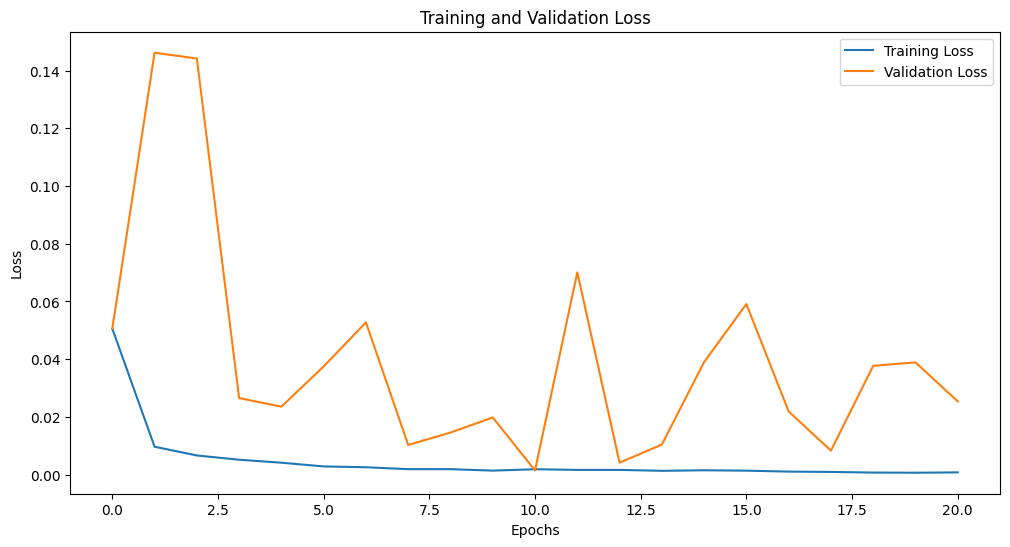

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load datasets
exogenous_data_path = '/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx'
training_data_path = '/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx'

exogenous_data = pd.read_excel(exogenous_data_path)
training_data = pd.read_excel(training_data_path)

# Extract necessary columns (drop 'Date' and keep 'idx' as target)
data = training_data.drop('Date', axis=1)

# Normalize the data for Transformer
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Prepare the training and validation sets
train_size = int(len(data_scaled) * 0.95)  # Use 95% for training
train, test = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 1:])  # Input features (all except idx)
        y.append(dataset[i + time_step, 0])  # Target (idx column)
    return np.array(X), np.array(y)

# Define time step (lookback window)
time_step = 30  # Increased to capture more historical context

# Create the datasets
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Define a more sophisticated Transformer-based model
class TransformerTimeSeriesModel(tf.keras.Model):
    def __init__(self, num_heads, ff_dim, num_features):
        super(TransformerTimeSeriesModel, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=num_features)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation="relu"), Dense(num_features)])
        self.dropout = Dropout(0.2)
        
    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)  # Self-attention
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Set model parameters
num_heads = 6  # Increased for more attention heads
ff_dim = 256  # Feed-forward layer size increased
num_features = X_train.shape[2]  # Number of features

# Inputs
inputs = Input(shape=(time_step, num_features))

# Transformer block
transformer_block = TransformerTimeSeriesModel(num_heads=num_heads, ff_dim=ff_dim, num_features=num_features)
x = transformer_block(inputs)

# Batch normalization for regularization
x = BatchNormalization()(x)

# Additional layers for better generalization
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Higher dropout to prevent overfitting
x = Dense(64, activation='relu')(x)

# Output layer to predict the target (idx)
outputs = Dense(1)(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Implement early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model with improved techniques
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100, 
                    batch_size=64, 
                    verbose=1, 
                    callbacks=[early_stopping, reduce_lr])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))], axis=1))[:, 0]

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)

train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Print model accuracy and performance
print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train R2: {train_r2}, Test R2: {test_r2}')
print(f'Train MAPE: {train_mape}%, Test MAPE: {test_mape}%')

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Data')
plt.plot(test_predict, label='Predicted Data')
plt.title('Predictions vs Actual Data')
plt.xlabel('Time Step')
plt.ylabel('idx')
plt.legend()
plt.show()

# Visualize training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



This code implements a Transformer-based model for time series forecasting. The model is trained on historical data to predict the future values of the target variable (idx). It uses Multi-Head Attention as the core mechanism, allowing it to capture dependencies across different time steps in the data. The model is built using the best hyperparameters identified from a prior tuning process, and it is trained and evaluated on a dataset split into training (2000-2022) and testing (2023) sets.

Step-by-Step Breakdown:
Data Loading:

The code starts by loading two datasets from .xlsx files:
exogenous_data_path: Exogenous factors (not used in the current model).
training_data_path: The main dataset, which includes a target column (idx) and other feature columns.
The 'Date' column is dropped, and the remaining data is normalized using MinMaxScaler to scale the features between 0 and 1, ensuring that the model can learn more effectively.
Train-Test Split:

The dataset is split into training (95%) and testing (5%) sets. This means the training data is from 2000 to 2022, and the test set is the data from 2023.
Create Input Sequences:

The function create_dataset generates input sequences (features) and their corresponding target values (idx). A sliding window of 30 time steps is used to capture dependencies over a historical time period.
The output is a dataset of sequences, where each sequence consists of 30 time steps of features, and the corresponding label is the value of idx for the next time step.
Model Architecture:

Transformer Block:
The core of the model is a Multi-Head Attention mechanism, with 2 attention heads based on the best hyperparameters.
Layer normalization is applied after the attention mechanism to stabilize training.
Feed-Forward Network:
After attention, a feed-forward neural network (FFN) with 128 hidden units (from the hyperparameter search) is applied.
Another layer normalization is applied after the feed-forward layer to ensure stability.
Global Average Pooling and Dense Layers:
The model includes a global average pooling layer to reduce the dimensionality, followed by dense layers with ReLU activation. Dropout is applied to prevent overfitting (with a dropout rate of 0.1).
Output Layer:
The output is a dense layer with a single neuron to predict the next value of idx.
Model Compilation and Training:

The model is compiled using the Adam optimizer with a learning rate of 0.00044849586684084973 (from the hyperparameter tuning).
The loss function is mean squared error (mse), and mean absolute error (mae) is used as an additional evaluation metric during training.
The model is trained for 50 epochs with a batch size of 64, using the training set for fitting and the test set for validation.
Model Evaluation:

After training, predictions are made on both the training and test sets.
Since the data was scaled during preprocessing, the predictions are inverse transformed back to their original scale for meaningful comparison with the actual values.
This ensures that the predicted and actual idx values are in their original, non-scaled form.
Plotting Predictions:

The predicted values (test_predict) are compared with the actual values (y_test) for the test set (2023 data).
A line plot is generated, showing the predicted values against the actual values to visualize how well the model performs on unseen test data.
Key Components:
Transformer-Based Model:
Multi-head attention captures relationships between different time steps within the input sequence, making the model well-suited for time series forecasting.
Feed-Forward Network:
After attention, dense layers process the output to make the final prediction.
Dropout Regularization:
A dropout layer with a rate of 0.1 prevents the model from overfitting on the training data.
Evaluation:
The model's predictions are compared against actual values, and performance is visualized using a plot that shows how close the predictions are to the actual target values for 2023.
Hyperparameters:
num_heads = 2 (for multi-head attention).
ff_dim = 128 (feed-forward network dimension).
dropout_rate = 0.1.
learning_rate = 0.00044849586684084973

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0583 - mae: 0.1666 - val_loss: 0.1528 - val_mae: 0.3858
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - mae: 0.0800 - val_loss: 0.0511 - val_mae: 0.2136
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0602 - val_loss: 0.0063 - val_mae: 0.0674
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - mae: 0.0545 - val_loss: 0.0265 - val_mae: 0.1527
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mae: 0.0450 - val_loss: 0.0041 - val_mae: 0.0551
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0403 - val_loss: 0.0104 - val_mae: 0.0920
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mae: 0.0348 - val_loss: 0.0159 - val_mae: 0.1156
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mae: 0.0345 - val_loss: 0.0200 - val_mae: 0.1343
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - mae

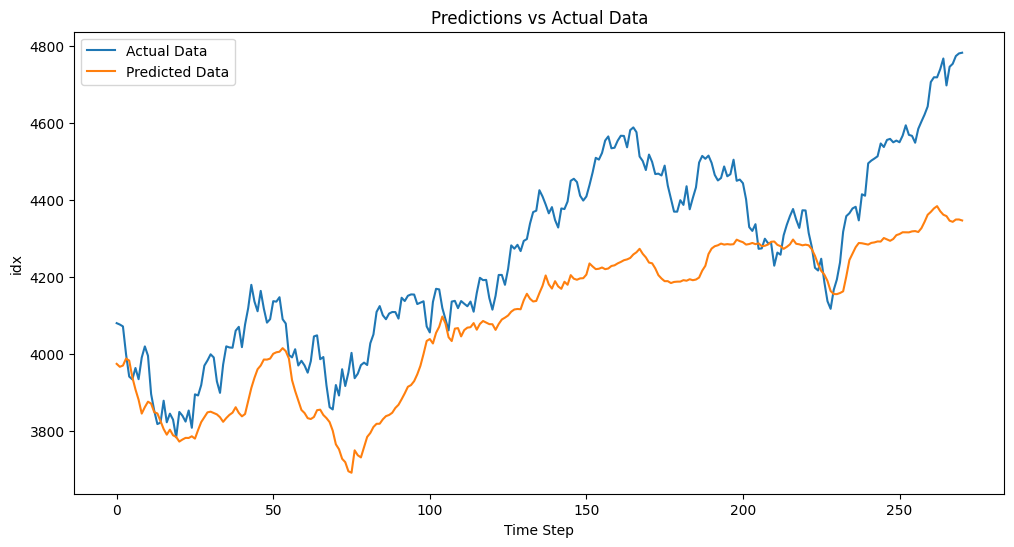

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load datasets (same as before)
exogenous_data_path = '/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx'
training_data_path = '/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx'

exogenous_data = pd.read_excel(exogenous_data_path)
training_data = pd.read_excel(training_data_path)

data = training_data.drop('Date', axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

train_size = int(len(data_scaled) * 0.95)  # Use 95% for training
train, test = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 1:])  # Input features (all except idx)
        y.append(dataset[i + time_step, 0])  # Target (idx column)
    return np.array(X), np.array(y)

# Time step setting (lookback window)
time_step = 30

X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Define the best model structure with the best hyperparameters
def build_best_model():
    num_heads = 2  # From best hyperparameters
    ff_dim = 128   # From best hyperparameters
    dropout_rate = 0.1  # From best hyperparameters
    learning_rate = 0.00044849586684084973  # From best hyperparameters

    num_features = X_train.shape[2]

    # Inputs
    inputs = Input(shape=(time_step, num_features))

    # Transformer block
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=num_features)(inputs, inputs)
    attention_out = LayerNormalization(epsilon=1e-6)(attention + inputs)

    # Feed-forward network
    ffn = Dense(ff_dim, activation='relu')(attention_out)
    ffn_out = Dense(num_features)(ffn)
    ffn_out = LayerNormalization(epsilon=1e-6)(ffn_out + attention_out)

    # Pooling and dropout layers
    x = BatchNormalization()(ffn_out)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)

    # Output layer
    outputs = Dense(1)(x)

    # Build and compile the model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])

    return model

# Build the best model
best_model = build_best_model()

# Train the best model
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Evaluate the best model
train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))], axis=1))[:, 0]

# Plot predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Data')
plt.plot(test_predict, label='Predicted Data')
plt.title('Predictions vs Actual Data')
plt.xlabel('Time Step')
plt.ylabel('idx')
plt.legend()
plt.show()


This code implements a Long Short-Term Memory (LSTM) neural network for time series forecasting, with a custom training loop that computes gradients based on test data (2023) and uses backpropagation to minimize the test loss.

Step-by-Step Breakdown:
Data Loading:

The code begins by loading two datasets from specific paths: exogenous_data_path and training_data_path in .xlsx format.
The training_data is used as the primary dataset, while the exogenous_data is loaded but not used in the code provided.
Data Preprocessing:

The 'Date' column is dropped from training_data, and the rest of the data is scaled to a range of [0, 1] using the MinMaxScaler to ensure that all features are normalized.
The dataset is split into training data (2000-2022) and test data (2023), with 95% of the dataset used for training.
Creating Input Sequences:

The create_dataset function takes the training or test data and converts it into sequences of features (inputs) and the target (the idx column) for prediction. A lookback window of 30 time steps is used to predict the next day's value.
Model Definition (LSTM):

The function build_lstm_model defines an LSTM-based neural network with the following components:
Two LSTM layers: The first LSTM layer returns sequences, and the second does not.
Batch Normalization: Applied after the LSTM layers for better training stability.
Dropout Layer: Applied after the LSTM layers to prevent overfitting.
Dense Output Layer: A single neuron output for predicting the next day's value of idx.
Hyperparameters:

The model is configured with the following hyperparameters:
lstm_units = 128: The number of units (neurons) in each LSTM layer.
dropout_rate = 0.2: The dropout rate to prevent overfitting.
learning_rate = 1e-4: The learning rate for the Adam optimizer.
epochs = 50: The number of epochs (iterations) for training.
batch_size = 64: The batch size for training.
Custom Training Loop:

A custom training loop is implemented using TensorFlow's GradientTape for manual backpropagation:
For each epoch, the training data is shuffled and divided into batches.
For each batch, a forward pass is performed on both the training data and the test data (2023).
The test loss is computed using the predictions on the test data, and gradients are computed based on this loss.
The model's weights are updated to minimize the test loss using the Adam optimizer.
Model Training:

After completing the custom training loop for all epochs, the model is used to make predictions on both the training data (X_train) and the test data (X_test).
Performance Evaluation:

Inverse Scaling: The predicted values are inverse-transformed to their original scale (before normalization) to compare with the actual values.
The model's performance is evaluated using several metrics:
RMSE (Root Mean Squared Error): Measures the square root of the average squared differences between predicted and actual values.
MAE (Mean Absolute Error): Measures the average absolute differences between predicted and actual values.
R² Score: Measures the proportion of variance explained by the model.
Results and Visualization:

After training, the model's predictions are compared with the actual values for the test data (2023).
A plot is generated to visualize Predicted vs. Actual values of idx over time, giving insight into the model's accuracy in forecasting.

Epoch 1/50
Train Loss: 0.2652580142021179, Test Loss (Backprop): 0.0010421532206237316
Epoch 2/50
Train Loss: 0.23335741460323334, Test Loss (Backprop): 0.0004118417564313859
Epoch 3/50
Train Loss: 0.17199735343456268, Test Loss (Backprop): 0.00023329038231167942
Epoch 4/50
Train Loss: 0.17709136009216309, Test Loss (Backprop): 0.00018345964781474322
Epoch 5/50
Train Loss: 0.17397281527519226, Test Loss (Backprop): 0.00015321765386033803
Epoch 6/50
Train Loss: 0.20337608456611633, Test Loss (Backprop): 0.00046970753464847803
Epoch 7/50
Train Loss: 0.06769520044326782, Test Loss (Backprop): 0.00010060056956717744
Epoch 8/50
Train Loss: 0.1665199100971222, Test Loss (Backprop): 9.589815454091877e-05
Epoch 9/50
Train Loss: 0.07540391385555267, Test Loss (Backprop): 9.590226545697078e-05
Epoch 10/50
Train Loss: 0.08626717329025269, Test Loss (Backprop): 5.728672840632498e-05
Epoch 11/50
Train Loss: 0.17260435223579407, Test Loss (Backprop): 4.838351742364466e-05
Epoch 12/50
Train Loss: 0.1

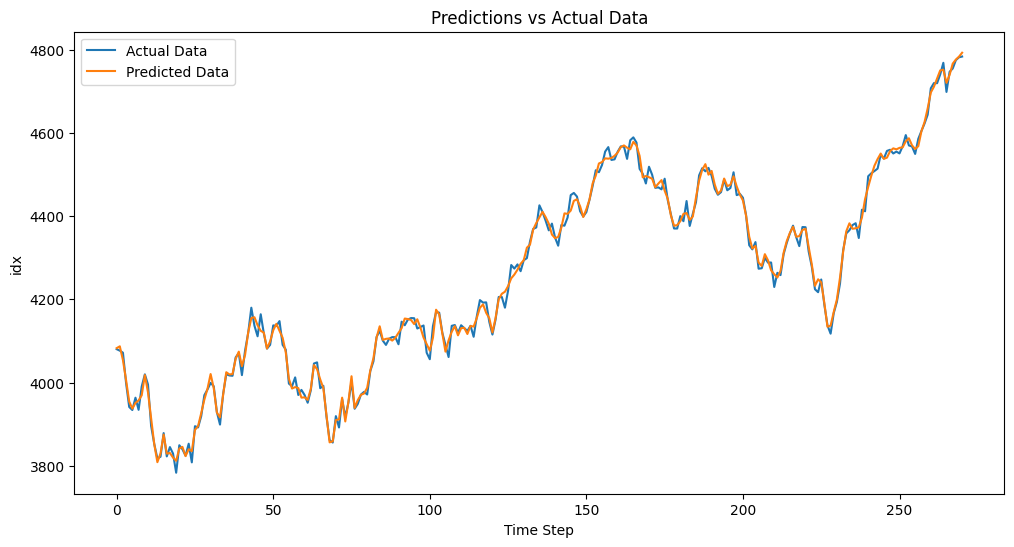

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model

# Load datasets (same as before)
exogenous_data_path = '/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx'
training_data_path = '/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx'

exogenous_data = pd.read_excel(exogenous_data_path)
training_data = pd.read_excel(training_data_path)

data = training_data.drop('Date', axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

train_size = int(len(data_scaled) * 0.95)  # Use 95% for training
train, test = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 1:])  # Input features (all except idx)
        y.append(dataset[i + time_step, 0])  # Target (idx column)
    return np.array(X), np.array(y)

# Time step setting (lookback window)
time_step = 30

X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Define the LSTM-based model structure
def build_lstm_model(lstm_units, dropout_rate):
    num_features = X_train.shape[2]
    
    inputs = Input(shape=(time_step, num_features))

    # LSTM layers
    x = LSTM(units=lstm_units, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(units=lstm_units)(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)

    # Output layer
    outputs = Dense(1)(x)

    # Build and compile the model
    model = Model(inputs, outputs)
    return model

# Hyperparameters
lstm_units = 128  # Number of LSTM units
dropout_rate = 0.2  # Dropout rate
learning_rate = 1e-4  # Learning rate
epochs = 50  # Number of epochs
batch_size = 64  # Batch size

# Build the model
model = build_lstm_model(lstm_units, dropout_rate)

# Optimizer and loss function
optimizer = Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

# Custom training loop using GradientTape for minimizing test loss
@tf.function
def train_step(X_train_batch, y_train_batch, X_test, y_test):
    with tf.GradientTape() as tape:
        # Forward pass on training data
        predictions_train = model(X_train_batch, training=True)
        loss_train = loss_fn(y_train_batch, predictions_train)

        # Forward pass on test data (2023 data)
        predictions_test = model(X_test, training=False)
        loss_test = loss_fn(y_test, predictions_test)

    # Compute gradients based on test loss
    gradients = tape.gradient(loss_test, model.trainable_variables)

    # Update weights to minimize test loss
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss_train, loss_test

# Prepare test data for backpropagation (2023 data)
X_test_tf = tf.convert_to_tensor(X_test)
y_test_tf = tf.convert_to_tensor(y_test)

# Custom training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Shuffle the training data for each epoch
    indices = np.random.permutation(len(X_train))
    X_train_shuffled, y_train_shuffled = X_train[indices], y_train[indices]

    # Training in batches
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size
        X_train_batch = X_train_shuffled[start:end]
        y_train_batch = y_train_shuffled[start:end]

        # Convert batches to tensors
        X_train_batch_tf = tf.convert_to_tensor(X_train_batch)
        y_train_batch_tf = tf.convert_to_tensor(y_train_batch)

        # Perform one training step
        loss_train, loss_test = train_step(X_train_batch_tf, y_train_batch_tf, X_test_tf, y_test_tf)

    print(f"Train Loss: {loss_train.numpy()}, Test Loss (Backprop): {loss_test.numpy()}")

# After training, make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))], axis=1))[:, 0]

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

# Print performance metrics
print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train R2: {train_r2}, Test R2: {test_r2}')

# Plot predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Data')
plt.plot(test_predict, label='Predicted Data')
plt.title('Predictions vs Actual Data')
plt.xlabel('Time Step')
plt.ylabel('idx')
plt.legend()
plt.show()
